<a href="https://colab.research.google.com/github/BenyaminZojaji/Deep_Learning/blob/main/PyTorch%20Face%20Age%20Regression/FaceAgeRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle
!ls -a ~/.kaggle

In [ ]:
!kaggle datasets download -d jangedoo/utkface-new
!unzip utkface-new.zip

In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split

In [44]:
# Hyper Parameters
width = height = 224
batch_size = 32
epochs = 20
lr = 0.001

In [45]:
images = [] # X
ages = [] # Y

for image_name in os.listdir('/content/utkface_aligned_cropped/crop_part1'):
  ages.append(int(image_name.split('_')[0]))

  image = cv2.imread(f'/content/utkface_aligned_cropped/crop_part1/{image_name}')
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image, (width, height))
  images.append(image)

In [46]:
images = pd.Series(images, name='Images')
ages = pd.Series(ages, name='Ages')

dataframe = pd.concat([images, ages], axis=1)
dataframe.head()

,Images,Ages
0,"[[[68, 50, 46], [66, 48, 44], [52, 33, 28], [3...",52
1,"[[[68, 17, 14], [64, 16, 12], [59, 15, 11], [5...",2
2,"[[[221, 203, 191], [222, 204, 192], [223, 204,...",1
3,"[[[177, 156, 129], [186, 165, 136], [194, 170,...",13
4,"[[[75, 64, 72], [77, 66, 75], [76, 66, 72], [7...",26


52


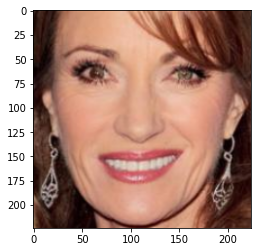

In [47]:
print(dataframe['Ages'][0])
plt.imshow(dataframe['Images'][0])
plt.show()

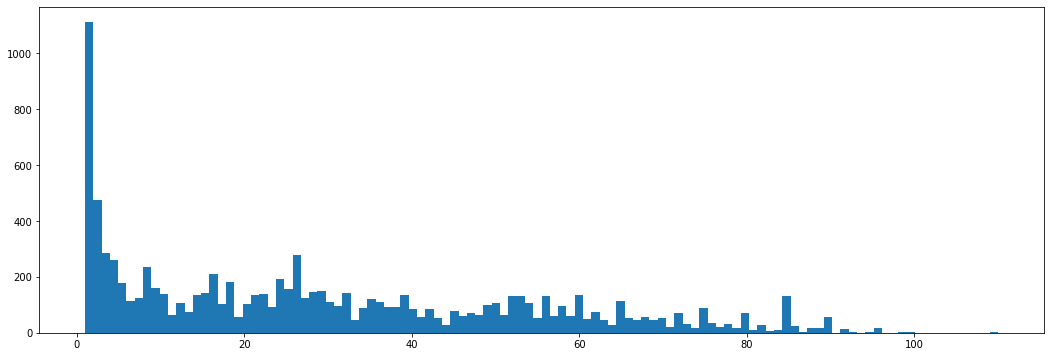

In [48]:
plt.figure(figsize=(18, 6))
plt.hist(dataframe['Ages'], bins=dataframe['Ages'].max())
plt.show()

In [49]:
under_4 = dataframe[dataframe['Ages'] <= 4]
under_4_new = under_4.sample(frac=0.3)

up_4 = dataframe[dataframe['Ages'] > 4]

dataframe = pd.concat([under_4_new, up_4], axis=0)

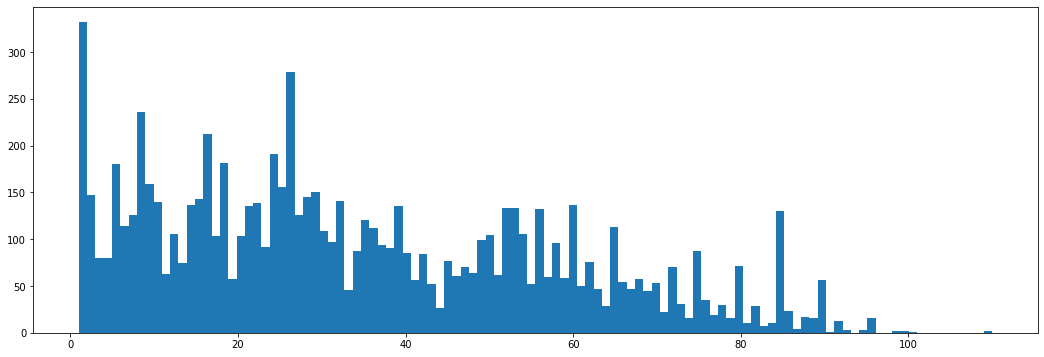

In [50]:
plt.figure(figsize=(18, 6))
plt.hist(dataframe['Ages'], bins=dataframe['Ages'].max())
plt.show()

In [51]:
X = np.array(dataframe['Images'].values.tolist())
Y = np.array(dataframe['Ages'].values.tolist())

In [52]:
print(X.shape)
print(Y.shape)

(8288, 224, 224, 3)
(8288,)


In [53]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2)

In [54]:
X_train = torch.tensor(X_train)
Y_train = torch.tensor(Y_train)

In [66]:
X_train.size()

torch.Size([6630, 224, 224, 3])

In [67]:
X_train = torch.permute(X_train, (0, 3, 2, 1))

In [68]:
X_train.size()

torch.Size([6630, 3, 224, 224])

In [69]:
class Dataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.data = X
        self.target = y
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]

        if self.transform:
            x = self.transform(x)

        return x, y
    
    def __len__(self):
        return len(self.data)

transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

In [70]:
dataset = Dataset(X_train, Y_train, transform)
train_data_loader = DataLoader(dataset, batch_size=batch_size)

In [75]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    # because they are RGB we put 3
    self.conv1 = nn.Conv2d(3, 32, (3, 3), (1, 1), (1, 1))
    self.conv2 = nn.Conv2d(32, 64, (3, 3), (1, 1), (1, 1))
    self.conv3 = nn.Conv2d(64, 128, (3, 3), (1, 1), (1, 1))
    self.conv4 = nn.Conv2d(128, 64, (3, 3), (1, 1), (1, 1))

    self.fc1 = nn.Linear(64*28*28, 512) # batch_size(?) * size * size (size after convs and maxpoolings)
    self.fc2 = nn.Linear(512, 1)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, kernel_size=(2, 2))
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, kernel_size=(2, 2))
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x, kernel_size=(2, 2))
    x = F.relu(self.conv4(x))
    #print(x.shape)
    x = torch.flatten(x, start_dim=1) # cuz we dont want to flatten all of it! (0 is batch size)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    x = torch.softmax(x, dim=1)
    return x

In [76]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Model().to(device)

In [81]:
# compile
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_function = nn.MSELoss()

In [82]:
model.train(True)

for epoch in range(epochs):
  train_loss = 0
  for images, labels in tqdm(train_data_loader):
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()

    preds = model(images)

    loss = loss_function(preds, labels.float())
    loss.backward()
    optimizer.step()

    train_loss += loss
  
  total_loss = train_loss / len(train_data_loader)

  print(f'Epoch: {epoch}, Loss: {total_loss}')

  0%|          | 0/208 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|█████████▉| 207/208 [00:26<00:00,  7.71it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 208/208 [00:27<00:00,  7.69it/s]


Epoch: 0, Loss: 1672.8521728515625


100%|██████████| 208/208 [00:26<00:00,  7.72it/s]


Epoch: 1, Loss: 1672.8521728515625


 27%|██▋       | 56/208 [00:10<00:28,  5.34it/s]


KeyboardInterrupt: ignored

In [ ]:
# save
torch.save(model.state_dict(), 'FaceAgeRegression.pth')